In [1]:
import stumpy
import pickle
import numpy as np
import time
import sklearn.metrics as metrics

from pipelinetools import *
from multiprocessing import Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
traces_train = load_traces('transformer_train')
traces_test = load_traces('transformer_test')
traces_kfp = load_traces('transformer_kfp')
train_pos = process_traces(traces_train, "p")
train_neg = process_traces(traces_train, "n")

100%|███████████████████████████████████████████| 51/51 [00:11<00:00,  4.56it/s]


In [97]:
def make_merged_trace_randsplit(traces_pos, traces_neg, chosen_class, num_random, num_traces):
    X_pos = []
    X_neg = []
    y = []

    for i in range(num_traces):
        true_id = random.choice([0, chosen_class])
        if true_id == 0:
            other_classes = [*range(50)]
            other_classes.remove(chosen_class)
            true_id = random.choice(other_classes)
        
        true_idx = random.randint(0,len(traces_pos[true_id])-1)
        
        random_idx = [random.randint(0,len(traces_pos[-1])-1) for i in range(num_random)]
        random_traces_pos = [traces_pos[-1][idx] for idx in random_idx]
        random_traces_neg = [traces_neg[-1][idx] for idx in random_idx]
        split_point = random.randint(0, num_random)
        
        
        combo_pos = np.concatenate(
            tuple(random_traces_pos[:split_point]) + 
            (traces_pos[true_id][true_idx], ) + 
            tuple(random_traces_pos[split_point:])
        )
        
        combo_neg = np.concatenate(
            tuple(random_traces_neg[:split_point]) + 
            (traces_neg[true_id][true_idx], ) + 
            tuple(random_traces_neg[split_point:])
        )

        X_pos.append(combo_pos)
        X_neg.append(combo_neg)
        
        if true_id == chosen_class:
            y.append(1)
        else:
            y.append(0)

    return X_pos, X_neg, y

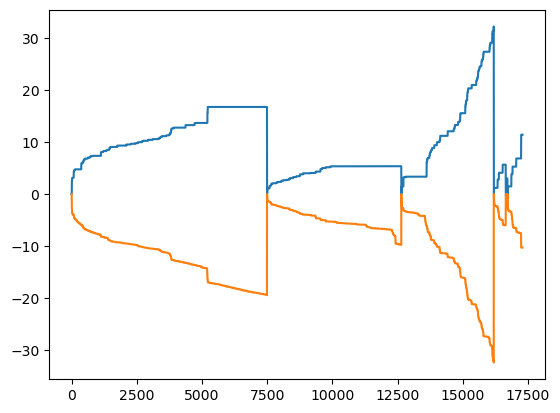

In [98]:
X_pos, X_neg, y = make_merged_trace_randsplit(train_pos, train_neg, chosen_class, 5, num_traces=1000)

plt.plot(X_pos[0])
plt.plot(X_neg[0])

In [3]:
def make_merged_trace(traces_pos, traces_neg, chosen_class, num_random, num_traces):
    X_pos = []
    X_neg = []
    y = []

    for i in tqdm(range(num_traces)):
        true_id = random.choice([0, chosen_class])
        if true_id == 0:
            other_classes = [*range(50)]
            other_classes.remove(chosen_class)
            true_id = random.choice(other_classes)
        
        true_idx = random.randint(0,len(traces_pos[true_id])-1)
        
        random_idx = [random.randint(0,len(traces_pos[-1])-1) for i in range(num_random)]
        random_traces_pos = tuple([traces_pos[-1][idx] for idx in random_idx[1:]])
        random_traces_neg = tuple([traces_neg[-1][idx] for idx in random_idx[1:]])
        
        
        combo_pos = np.concatenate(
            (traces_pos[-1][random_idx[0]],traces_pos[true_id][true_idx]) + random_traces_pos
        )
        
        combo_neg = np.concatenate(
            (traces_neg[-1][random_idx[0]],traces_neg[true_id][true_idx]) + random_traces_neg
        )

        X_pos.append(combo_pos)
        X_neg.append(combo_neg)
        
        if true_id == chosen_class:
            y.append(1)
        else:
            y.append(0)

    return X_pos, X_neg, y

In [4]:
def get_parameter_list(filenames_pos, filenames_neg, shapelets_pos, shapelets_neg, X_pos, X_neg, y):
    parameter_list = [] 
    
    for i in range(len(filenames_pos)):
        parameter_set = [
            filenames_pos[i],
            X_pos,
            y,
            shapelets_pos[i],
            "stumpy"
        ]
        parameter_list.append(parameter_set)
    
    for i in range(len(filenames_neg)):
        parameter_set = [
            filenames_neg[i],
            X_neg,
            y,
            shapelets_neg[i],
            "stumpy"
        ]
        parameter_list.append(parameter_set)
    
    return parameter_list

In [28]:
def generate_names(chosen_class, num_shapelets=2):
    
    filenames_pos = make_name_list({
        'type':['pos'],
        'centroid_id':list(range(num_shapelets)),
        'class_id':[chosen_class],
    })
    filenames_neg = make_name_list({
        'type':['neg'],
        'centroid_id':list(range(num_shapelets)),
        'class_id':[chosen_class],
    })

    return filenames_pos, filenames_neg

In [6]:
def classify_shapes(filenames_pos, filenames_neg):
    X_pos, y = load_xy(filenames_pos, True)
    X_neg, y = load_xy(filenames_neg, True)
    X = np.concatenate((X_pos, X_neg), axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    
    return score

In [35]:
num_classes = 15
num_shapelets = 7

scores = np.empty((num_classes, num_shapelets-2))

for chosen_class in tqdm(range(num_classes)):

    X_pos, X_neg, y = make_merged_trace(train_pos, train_neg, chosen_class, num_random=2, num_traces=1000)
    
    for chosen_shapelet in range(2, num_shapelets):
        shapelets_pos = generate_random_shapelets(train_pos, chosen_shapelet)
        shapelets_neg = generate_random_shapelets(train_neg, chosen_shapelet)
        filenames_pos, filenames_neg = generate_names(chosen_class, num_shapelets=chosen_shapelet)
        
        parameter_list = get_parameter_list(filenames_pos, filenames_neg, shapelets_pos, shapelets_neg, X_pos, X_neg, y)
        
        with Pool(4) as p:
            p.map(compute_shapelet_distances_mp, parameter_list)
        score = classify_shapes(filenames_pos, filenames_neg)
        
        scores[chosen_class][chosen_shapelet-2] = score

print(scores)

100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=0
Saving y as ../results/data/y/type=negcentroid_id=1class_id=0
Saving X as ../results/data/X/type=negcentroid_id=0class_id=0
Saving y as ../results/data/y/type=negcentroid_id=0class_id=0
Saving X as ../results/data/X/type=poscentroid_id=1class_id=0
Saving y as ../results/data/y/type=poscentroid_id=1class_id=0
Loading X from ../results/data/X/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=1class_id=0
Loading y from ../results/data/y/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=1class_id=0
Loading y from ../results/data/y/type=negcentroid_id=0class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s] 3.35it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=0
Saving y as ../results/data/y/type=poscentroid_id=2class_id=0


 96%|█████████▌| 960/1000 [05:10<00:13,  3.03it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=0
Saving y as ../results/data/y/type=negcentroid_id=0class_id=0


100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


Saving X as ../results/data/X/type=poscentroid_id=0class_id=0
Saving y as ../results/data/y/type=poscentroid_id=0class_id=0
Saving X as ../results/data/X/type=poscentroid_id=1class_id=0
Saving y as ../results/data/y/type=poscentroid_id=1class_id=0
Saving X as ../results/data/X/type=negcentroid_id=2class_id=0
Saving y as ../results/data/y/type=negcentroid_id=2class_id=0
Saving X as ../results/data/X/type=negcentroid_id=1class_id=0
Saving y as ../results/data/y/type=negcentroid_id=1class_id=0
Loading X from ../results/data/X/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=1class_id=0
Loading X from ../results/data/X/type=poscentroid_id=2class_id=0
Loading y from ../results/data/y/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=1class_id=0
Loading X from ../results/data/X/type=negcentroid_id=2class_id=0
Loading y from ../results/data/y/type=negcentroid

 99%|█████████▉| 991/1000 [04:54<00:01,  5.37it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=0
Saving y as ../results/data/y/type=poscentroid_id=2class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s] 4.73it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=0
Saving y as ../results/data/y/type=poscentroid_id=3class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s]2.46it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=0
Saving y as ../results/data/y/type=poscentroid_id=0class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s]3.79it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=0
Saving y as ../results/data/y/type=poscentroid_id=1class_id=0


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=0
Saving y as ../results/data/y/type=negcentroid_id=2class_id=0
Saving X as ../results/data/X/type=negcentroid_id=0class_id=0
Saving y as ../results/data/y/type=negcentroid_id=0class_id=0
Saving X as ../results/data/X/type=negcentroid_id=1class_id=0
Saving y as ../results/data/y/type=negcentroid_id=1class_id=0
Loading X from ../results/data/X/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=1class_id=0
Loading X from ../results/data/X/type=poscentroid_id=2class_id=0
Loading X from ../results/data/X/type=poscentroid_id=3class_id=0
Loading y from ../results/data/y/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=1class_id=0
Loading X from ../results/data/X/type=negcentroid_id=2class_id=0
Loading X from ../results/data/X/type=negcentroid_id=3class_id=0
Loading y from ../results/data/y/type=negce

 98%|█████████▊| 975/1000 [05:08<00:05,  4.76it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=0
Saving y as ../results/data/y/type=poscentroid_id=0class_id=0


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=0
Saving y as ../results/data/y/type=poscentroid_id=2class_id=0
Saving X as ../results/data/X/type=poscentroid_id=3class_id=0
Saving y as ../results/data/y/type=poscentroid_id=3class_id=0


  1%|          | 6/1000 [00:04<16:14,  1.02it/s]]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=0
Saving y as ../results/data/y/type=poscentroid_id=1class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s] 3.19it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=0
Saving y as ../results/data/y/type=poscentroid_id=4class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s] 4.67it/s]

Saving X as ../results/data/X/type=negcentroid_id=2class_id=0
Saving y as ../results/data/y/type=negcentroid_id=2class_id=0


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=0
Saving y as ../results/data/y/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=1class_id=0
Loading X from ../results/data/X/type=poscentroid_id=2class_id=0
Loading X from ../results/data/X/type=poscentroid_id=3class_id=0
Loading X from ../results/data/X/type=poscentroid_id=4class_id=0
Loading y from ../results/data/y/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=1class_id=0
Loading X from ../results/data/X/type=negcentroid_id=2class_id=0
Loading X from ../results/data/X/type=negcentroid_id=3class_id=0
Loading X from ../results/data/X/type=negcentroid_id=4class_id=0
Loading y from ../results/data/y/type=negcentroid_id=0class_id=0


 99%|█████████▉| 991/1000 [04:55<00:01,  5.29it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=0
Saving y as ../results/data/y/type=poscentroid_id=3class_id=0


 94%|█████████▎| 937/1000 [04:57<00:14,  4.39it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=0
Saving y as ../results/data/y/type=poscentroid_id=0class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s] 4.40it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=0
Saving y as ../results/data/y/type=poscentroid_id=1class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s]4.79it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=0
Saving y as ../results/data/y/type=poscentroid_id=2class_id=0


100%|██████████| 1000/1000 [04:44<00:00,  3.52it/s]


Saving X as ../results/data/X/type=poscentroid_id=5class_id=0
Saving y as ../results/data/y/type=poscentroid_id=5class_id=0


 95%|█████████▌| 951/1000 [05:02<00:12,  3.80it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=0
Saving y as ../results/data/y/type=poscentroid_id=4class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s] 4.02it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=0
Saving y as ../results/data/y/type=negcentroid_id=0class_id=0


  0%|          | 0/1000 [00:00<?, ?it/s]3.96it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=0
Saving y as ../results/data/y/type=negcentroid_id=1class_id=0


100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=0
Saving y as ../results/data/y/type=negcentroid_id=2class_id=0
Saving X as ../results/data/X/type=negcentroid_id=3class_id=0
Saving y as ../results/data/y/type=negcentroid_id=3class_id=0
Saving X as ../results/data/X/type=negcentroid_id=4class_id=0
Saving y as ../results/data/y/type=negcentroid_id=4class_id=0
Loading X from ../results/data/X/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=1class_id=0
Loading X from ../results/data/X/type=poscentroid_id=2class_id=0
Loading X from ../results/data/X/type=poscentroid_id=3class_id=0
Loading X from ../results/data/X/type=poscentroid_id=4class_id=0
Loading X from ../results/data/X/type=poscentroid_id=5class_id=0
Loading y from ../results/data/y/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=1class_id=0
Loading X from ../results/data/X/type=negce

100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=1
Saving y as ../results/data/y/type=negcentroid_id=1class_id=1
Saving X as ../results/data/X/type=poscentroid_id=1class_id=1
Saving y as ../results/data/y/type=poscentroid_id=1class_id=1
Saving X as ../results/data/X/type=poscentroid_id=0class_id=1
Saving y as ../results/data/y/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=poscentroid_id=1class_id=1
Loading y from ../results/data/y/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=1class_id=1
Loading y from ../results/data/y/type=negcentroid_id=0class_id=1


  0%|          | 0/1000 [00:00<?, ?it/s] 5.24it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=1
Saving y as ../results/data/y/type=poscentroid_id=2class_id=1


 98%|█████████▊| 985/1000 [04:46<00:02,  5.11it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=1
Saving y as ../results/data/y/type=poscentroid_id=0class_id=1


100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=1
Saving y as ../results/data/y/type=negcentroid_id=0class_id=1
Saving X as ../results/data/X/type=poscentroid_id=1class_id=1
Saving y as ../results/data/y/type=poscentroid_id=1class_id=1
Saving X as ../results/data/X/type=negcentroid_id=1class_id=1
Saving y as ../results/data/y/type=negcentroid_id=1class_id=1
Loading X from ../results/data/X/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=poscentroid_id=1class_id=1
Loading X from ../results/data/X/type=poscentroid_id=2class_id=1
Loading y from ../results/data/y/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=1class_id=1
Loading X from ../results/data/X/type=negcentroid_id=2class_id=1
Loading y from ../results/data/y/type=negcentroid_id=0class_id=1


  0%|          | 1/1000 [00:00<03:06,  5.37it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=1
Saving y as ../results/data/y/type=poscentroid_id=3class_id=1


 93%|█████████▎| 927/1000 [04:51<00:15,  4.67it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=1
Saving y as ../results/data/y/type=poscentroid_id=2class_id=1


  6%|▋         | 65/1000 [00:18<03:06,  5.01it/s]]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=1
Saving y as ../results/data/y/type=poscentroid_id=1class_id=1


  4%|▍         | 42/1000 [00:11<04:04,  3.92it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=1
Saving y as ../results/data/y/type=poscentroid_id=0class_id=1


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=1
Saving y as ../results/data/y/type=negcentroid_id=0class_id=1
Saving X as ../results/data/X/type=negcentroid_id=1class_id=1
Saving y as ../results/data/y/type=negcentroid_id=1class_id=1
Saving X as ../results/data/X/type=negcentroid_id=2class_id=1
Saving y as ../results/data/y/type=negcentroid_id=2class_id=1
Loading X from ../results/data/X/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=poscentroid_id=1class_id=1
Loading X from ../results/data/X/type=poscentroid_id=2class_id=1
Loading X from ../results/data/X/type=poscentroid_id=3class_id=1
Loading y from ../results/data/y/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=1class_id=1
Loading X from ../results/data/X/type=negcentroid_id=2class_id=1
Loading X from ../results/data/X/type=negcentroid_id=3class_id=1
Loading y from ../results/data/y/type=negce

 95%|█████████▌| 954/1000 [04:29<00:12,  3.68it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=1
Saving y as ../results/data/y/type=poscentroid_id=0class_id=1


  0%|          | 0/1000 [00:00<?, ?it/s]3.38it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=1
Saving y as ../results/data/y/type=poscentroid_id=1class_id=1


 96%|█████████▌| 956/1000 [04:41<00:11,  3.83it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=1
Saving y as ../results/data/y/type=poscentroid_id=2class_id=1


  0%|          | 0/1000 [00:00<?, ?it/s]4.78it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=1
Saving y as ../results/data/y/type=poscentroid_id=3class_id=1


100%|██████████| 1000/1000 [04:44<00:00,  3.52it/s]


Saving X as ../results/data/X/type=poscentroid_id=4class_id=1
Saving y as ../results/data/y/type=poscentroid_id=4class_id=1


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=1
Saving y as ../results/data/y/type=negcentroid_id=1class_id=1


100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=1
Saving y as ../results/data/y/type=negcentroid_id=2class_id=1
Saving X as ../results/data/X/type=negcentroid_id=0class_id=1
Saving y as ../results/data/y/type=negcentroid_id=0class_id=1
Saving X as ../results/data/X/type=negcentroid_id=3class_id=1
Saving y as ../results/data/y/type=negcentroid_id=3class_id=1
Loading X from ../results/data/X/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=poscentroid_id=1class_id=1
Loading X from ../results/data/X/type=poscentroid_id=2class_id=1
Loading X from ../results/data/X/type=poscentroid_id=3class_id=1
Loading X from ../results/data/X/type=poscentroid_id=4class_id=1
Loading y from ../results/data/y/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid_id=1class_id=1
Loading X from ../results/data/X/type=negcentroid_id=2class_id=1
Loading X from ../results/data/X/type=negce

  0%|          | 0/1000 [00:00<?, ?it/s] 5.70it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=1
Saving y as ../results/data/y/type=poscentroid_id=1class_id=1


  1%|          | 7/1000 [00:01<04:42,  3.52it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=1
Saving y as ../results/data/y/type=poscentroid_id=0class_id=1


 99%|█████████▉| 988/1000 [04:47<00:01,  6.37it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=1
Saving y as ../results/data/y/type=poscentroid_id=3class_id=1


  0%|          | 0/1000 [00:00<?, ?it/s]3.71it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=1
Saving y as ../results/data/y/type=poscentroid_id=2class_id=1


  0%|          | 0/1000 [00:00<?, ?it/s] 3.18it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=1
Saving y as ../results/data/y/type=poscentroid_id=5class_id=1


  0%|          | 0/1000 [00:00<?, ?it/s] 4.56it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=1
Saving y as ../results/data/y/type=negcentroid_id=0class_id=1


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


Saving X as ../results/data/X/type=poscentroid_id=4class_id=1
Saving y as ../results/data/y/type=poscentroid_id=4class_id=1


 12%|█▏        | 115/1000 [00:31<05:46,  2.55it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=1
Saving y as ../results/data/y/type=negcentroid_id=1class_id=1


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=1
Saving y as ../results/data/y/type=negcentroid_id=2class_id=1
Saving X as ../results/data/X/type=negcentroid_id=3class_id=1
Saving y as ../results/data/y/type=negcentroid_id=3class_id=1
Saving X as ../results/data/X/type=negcentroid_id=4class_id=1
Saving y as ../results/data/y/type=negcentroid_id=4class_id=1
Saving X as ../results/data/X/type=negcentroid_id=5class_id=1
Saving y as ../results/data/y/type=negcentroid_id=5class_id=1
Loading X from ../results/data/X/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=poscentroid_id=1class_id=1
Loading X from ../results/data/X/type=poscentroid_id=2class_id=1
Loading X from ../results/data/X/type=poscentroid_id=3class_id=1
Loading X from ../results/data/X/type=poscentroid_id=4class_id=1
Loading X from ../results/data/X/type=poscentroid_id=5class_id=1
Loading y from ../results/data/y/type=poscentroid_id=0class_id=1
Loading X from ../results/data/X/type=negcentroid

100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


Saving X as ../results/data/X/type=poscentroid_id=0class_id=2
Saving y as ../results/data/y/type=poscentroid_id=0class_id=2
Saving X as ../results/data/X/type=poscentroid_id=1class_id=2
Saving y as ../results/data/y/type=poscentroid_id=1class_id=2
Saving X as ../results/data/X/type=negcentroid_id=0class_id=2
Saving y as ../results/data/y/type=negcentroid_id=0class_id=2
Loading X from ../results/data/X/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=poscentroid_id=1class_id=2
Loading y from ../results/data/y/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=1class_id=2
Loading y from ../results/data/y/type=negcentroid_id=0class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 3.28it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=2
Saving y as ../results/data/y/type=poscentroid_id=1class_id=2


 99%|█████████▉| 988/1000 [04:27<00:03,  3.12it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=2
Saving y as ../results/data/y/type=poscentroid_id=2class_id=2


100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=2
Saving y as ../results/data/y/type=negcentroid_id=0class_id=2
Saving X as ../results/data/X/type=poscentroid_id=0class_id=2
Saving y as ../results/data/y/type=poscentroid_id=0class_id=2
Saving X as ../results/data/X/type=negcentroid_id=2class_id=2
Saving y as ../results/data/y/type=negcentroid_id=2class_id=2
Loading X from ../results/data/X/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=poscentroid_id=1class_id=2
Loading X from ../results/data/X/type=poscentroid_id=2class_id=2
Loading y from ../results/data/y/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=1class_id=2
Loading X from ../results/data/X/type=negcentroid_id=2class_id=2
Loading y from ../results/data/y/type=negcentroid_id=0class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 4.83it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=2
Saving y as ../results/data/y/type=poscentroid_id=3class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 1.45it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=2
Saving y as ../results/data/y/type=poscentroid_id=1class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 3.86it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=2
Saving y as ../results/data/y/type=poscentroid_id=0class_id=2


 10%|█         | 100/1000 [00:27<04:03,  3.69it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=2
Saving y as ../results/data/y/type=poscentroid_id=2class_id=2


100%|██████████| 1000/1000 [04:34<00:00,  3.65it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=2
Saving y as ../results/data/y/type=negcentroid_id=1class_id=2
Saving X as ../results/data/X/type=negcentroid_id=0class_id=2
Saving y as ../results/data/y/type=negcentroid_id=0class_id=2
Loading X from ../results/data/X/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=poscentroid_id=1class_id=2
Loading X from ../results/data/X/type=poscentroid_id=2class_id=2
Loading X from ../results/data/X/type=poscentroid_id=3class_id=2
Loading y from ../results/data/y/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=1class_id=2
Loading X from ../results/data/X/type=negcentroid_id=2class_id=2
Loading X from ../results/data/X/type=negcentroid_id=3class_id=2
Loading y from ../results/data/y/type=negcentroid_id=0class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 5.52it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=2
Saving y as ../results/data/y/type=poscentroid_id=2class_id=2


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=2
Saving y as ../results/data/y/type=poscentroid_id=1class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 4.44it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=2
Saving y as ../results/data/y/type=poscentroid_id=3class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s]2.43it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=2
Saving y as ../results/data/y/type=poscentroid_id=0class_id=2


100%|██████████| 1000/1000 [04:33<00:00,  3.65it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=2
Saving y as ../results/data/y/type=negcentroid_id=0class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 4.84it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=2
Saving y as ../results/data/y/type=negcentroid_id=1class_id=2


100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=2
Saving y as ../results/data/y/type=negcentroid_id=2class_id=2
Saving X as ../results/data/X/type=poscentroid_id=4class_id=2
Saving y as ../results/data/y/type=poscentroid_id=4class_id=2
Loading X from ../results/data/X/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=poscentroid_id=1class_id=2
Loading X from ../results/data/X/type=poscentroid_id=2class_id=2
Loading X from ../results/data/X/type=poscentroid_id=3class_id=2
Loading X from ../results/data/X/type=poscentroid_id=4class_id=2
Loading y from ../results/data/y/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=1class_id=2
Loading X from ../results/data/X/type=negcentroid_id=2class_id=2
Loading X from ../results/data/X/type=negcentroid_id=3class_id=2
Loading X from ../results/data/X/type=negcentroid_id=4class_id=2
Loading y from ../results/data/y/type

 97%|█████████▋| 967/1000 [04:32<00:06,  5.20it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=2
Saving y as ../results/data/y/type=poscentroid_id=3class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s]3.28it/s]]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=2
Saving y as ../results/data/y/type=poscentroid_id=0class_id=2


  1%|          | 6/1000 [00:01<02:54,  5.69it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=2
Saving y as ../results/data/y/type=poscentroid_id=2class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=2
Saving y as ../results/data/y/type=poscentroid_id=1class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s] 4.94it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=2
Saving y as ../results/data/y/type=negcentroid_id=0class_id=2


 98%|█████████▊| 976/1000 [04:36<00:05,  4.61it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=2
Saving y as ../results/data/y/type=poscentroid_id=4class_id=2


100%|█████████▉| 997/1000 [04:42<00:00,  3.22it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=2
Saving y as ../results/data/y/type=poscentroid_id=5class_id=2


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=2
Saving y as ../results/data/y/type=negcentroid_id=1class_id=2


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


Saving X as ../results/data/X/type=negcentroid_id=3class_id=2
Saving y as ../results/data/y/type=negcentroid_id=3class_id=2
Saving X as ../results/data/X/type=negcentroid_id=2class_id=2
Saving y as ../results/data/y/type=negcentroid_id=2class_id=2
Saving X as ../results/data/X/type=negcentroid_id=5class_id=2
Saving y as ../results/data/y/type=negcentroid_id=5class_id=2
Loading X from ../results/data/X/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=poscentroid_id=1class_id=2
Loading X from ../results/data/X/type=poscentroid_id=2class_id=2
Loading X from ../results/data/X/type=poscentroid_id=3class_id=2
Loading X from ../results/data/X/type=poscentroid_id=4class_id=2
Loading X from ../results/data/X/type=poscentroid_id=5class_id=2
Loading y from ../results/data/y/type=poscentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=0class_id=2
Loading X from ../results/data/X/type=negcentroid_id=1class_id=2
Loading X from ../results/data/X/type=negce

100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=3
Saving y as ../results/data/y/type=poscentroid_id=1class_id=3
Saving X as ../results/data/X/type=poscentroid_id=0class_id=3
Saving y as ../results/data/y/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=poscentroid_id=1class_id=3
Loading y from ../results/data/y/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=1class_id=3
Loading y from ../results/data/y/type=negcentroid_id=0class_id=3


  0%|          | 0/1000 [00:00<?, ?it/s] 4.00it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=3
Saving y as ../results/data/y/type=poscentroid_id=0class_id=3


  4%|▍         | 45/1000 [00:13<03:13,  4.94it/s]]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=3
Saving y as ../results/data/y/type=negcentroid_id=0class_id=3


100%|██████████| 1000/1000 [04:48<00:00,  3.46it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=3
Saving y as ../results/data/y/type=poscentroid_id=1class_id=3
Saving X as ../results/data/X/type=poscentroid_id=2class_id=3
Saving y as ../results/data/y/type=poscentroid_id=2class_id=3
Saving X as ../results/data/X/type=negcentroid_id=1class_id=3
Saving y as ../results/data/y/type=negcentroid_id=1class_id=3
Loading X from ../results/data/X/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=poscentroid_id=1class_id=3
Loading X from ../results/data/X/type=poscentroid_id=2class_id=3
Loading y from ../results/data/y/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=1class_id=3
Loading X from ../results/data/X/type=negcentroid_id=2class_id=3
Loading y from ../results/data/y/type=negcentroid_id=0class_id=3


  0%|          | 0/1000 [00:00<?, ?it/s] 2.94it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=3
Saving y as ../results/data/y/type=poscentroid_id=1class_id=3


  0%|          | 0/1000 [00:00<?, ?it/s]4.17it/s]]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=3
Saving y as ../results/data/y/type=poscentroid_id=3class_id=3


  6%|▌         | 57/1000 [00:20<03:56,  4.00it/s]]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=3
Saving y as ../results/data/y/type=poscentroid_id=2class_id=3


  6%|▌         | 60/1000 [00:21<05:11,  3.02it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=3
Saving y as ../results/data/y/type=poscentroid_id=0class_id=3


100%|██████████| 1000/1000 [05:40<00:00,  2.93it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=3
Saving y as ../results/data/y/type=negcentroid_id=0class_id=3
Saving X as ../results/data/X/type=negcentroid_id=1class_id=3
Saving y as ../results/data/y/type=negcentroid_id=1class_id=3
Saving X as ../results/data/X/type=negcentroid_id=3class_id=3
Saving y as ../results/data/y/type=negcentroid_id=3class_id=3
Loading X from ../results/data/X/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=poscentroid_id=1class_id=3
Loading X from ../results/data/X/type=poscentroid_id=2class_id=3
Loading X from ../results/data/X/type=poscentroid_id=3class_id=3
Loading y from ../results/data/y/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=1class_id=3
Loading X from ../results/data/X/type=negcentroid_id=2class_id=3
Loading X from ../results/data/X/type=negcentroid_id=3class_id=3
Loading y from ../results/data/y/type=negce

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=3
Saving y as ../results/data/y/type=poscentroid_id=1class_id=3


100%|█████████▉| 997/1000 [04:57<00:00,  3.82it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=3
Saving y as ../results/data/y/type=poscentroid_id=0class_id=3


  0%|          | 2/1000 [00:00<05:57,  2.79it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=3
Saving y as ../results/data/y/type=poscentroid_id=3class_id=3


  0%|          | 2/1000 [00:00<05:59,  2.78it/s]]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=3
Saving y as ../results/data/y/type=poscentroid_id=2class_id=3


 99%|█████████▊| 987/1000 [04:55<00:03,  3.89it/s]

Saving X as ../results/data/X/type=negcentroid_id=2class_id=3
Saving y as ../results/data/y/type=negcentroid_id=2class_id=3


  0%|          | 0/1000 [00:00<?, ?it/s] 3.47it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=3
Saving y as ../results/data/y/type=negcentroid_id=1class_id=3


100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s]


Saving X as ../results/data/X/type=poscentroid_id=4class_id=3
Saving y as ../results/data/y/type=poscentroid_id=4class_id=3
Saving X as ../results/data/X/type=negcentroid_id=0class_id=3
Saving y as ../results/data/y/type=negcentroid_id=0class_id=3
Loading X from ../results/data/X/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=poscentroid_id=1class_id=3
Loading X from ../results/data/X/type=poscentroid_id=2class_id=3
Loading X from ../results/data/X/type=poscentroid_id=3class_id=3
Loading X from ../results/data/X/type=poscentroid_id=4class_id=3
Loading y from ../results/data/y/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=1class_id=3
Loading X from ../results/data/X/type=negcentroid_id=2class_id=3
Loading X from ../results/data/X/type=negcentroid_id=3class_id=3
Loading X from ../results/data/X/type=negcentroid_id=4class_id=3
Loading y from ../results/data/y/type

  0%|          | 0/1000 [00:00<?, ?it/s] 2.85it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=3
Saving y as ../results/data/y/type=poscentroid_id=2class_id=3


 98%|█████████▊| 980/1000 [04:50<00:04,  4.03it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=3
Saving y as ../results/data/y/type=poscentroid_id=3class_id=3


  2%|▏         | 23/1000 [00:07<03:40,  4.42it/s]]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=3
Saving y as ../results/data/y/type=poscentroid_id=0class_id=3


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=3
Saving y as ../results/data/y/type=poscentroid_id=1class_id=3


  0%|          | 0/1000 [00:00<?, ?it/s] 2.34it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=3
Saving y as ../results/data/y/type=poscentroid_id=4class_id=3


  0%|          | 0/1000 [00:00<?, ?it/s] 3.42it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=3
Saving y as ../results/data/y/type=negcentroid_id=0class_id=3


  2%|▏         | 18/1000 [00:06<04:26,  3.68it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=3
Saving y as ../results/data/y/type=poscentroid_id=5class_id=3


  4%|▍         | 38/1000 [00:12<05:19,  3.02it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=3
Saving y as ../results/data/y/type=negcentroid_id=1class_id=3


100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=3
Saving y as ../results/data/y/type=negcentroid_id=2class_id=3
Saving X as ../results/data/X/type=negcentroid_id=4class_id=3
Saving y as ../results/data/y/type=negcentroid_id=4class_id=3
Saving X as ../results/data/X/type=negcentroid_id=3class_id=3
Saving y as ../results/data/y/type=negcentroid_id=3class_id=3
Loading X from ../results/data/X/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=poscentroid_id=1class_id=3
Loading X from ../results/data/X/type=poscentroid_id=2class_id=3
Loading X from ../results/data/X/type=poscentroid_id=3class_id=3
Loading X from ../results/data/X/type=poscentroid_id=4class_id=3
Loading X from ../results/data/X/type=poscentroid_id=5class_id=3
Loading y from ../results/data/y/type=poscentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=0class_id=3
Loading X from ../results/data/X/type=negcentroid_id=1class_id=3
Loading X from ../results/data/X/type=negce

100%|██████████| 1000/1000 [05:51<00:00,  2.84it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=4
Saving y as ../results/data/y/type=poscentroid_id=1class_id=4
Saving X as ../results/data/X/type=negcentroid_id=1class_id=4
Saving y as ../results/data/y/type=negcentroid_id=1class_id=4
Loading X from ../results/data/X/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=poscentroid_id=1class_id=4
Loading y from ../results/data/y/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=1class_id=4
Loading y from ../results/data/y/type=negcentroid_id=0class_id=4


 94%|█████████▎| 936/1000 [05:34<00:16,  3.98it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=4
Saving y as ../results/data/y/type=poscentroid_id=1class_id=4


  0%|          | 0/1000 [00:00<?, ?it/s] 3.61it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=4
Saving y as ../results/data/y/type=negcentroid_id=0class_id=4


100%|██████████| 1000/1000 [05:41<00:00,  2.92it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=4
Saving y as ../results/data/y/type=poscentroid_id=2class_id=4
Saving X as ../results/data/X/type=poscentroid_id=0class_id=4
Saving y as ../results/data/y/type=poscentroid_id=0class_id=4
Saving X as ../results/data/X/type=negcentroid_id=2class_id=4
Saving y as ../results/data/y/type=negcentroid_id=2class_id=4
Loading X from ../results/data/X/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=poscentroid_id=1class_id=4
Loading X from ../results/data/X/type=poscentroid_id=2class_id=4
Loading y from ../results/data/y/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=1class_id=4
Loading X from ../results/data/X/type=negcentroid_id=2class_id=4
Loading y from ../results/data/y/type=negcentroid_id=0class_id=4


 93%|█████████▎| 931/1000 [05:38<00:15,  4.46it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=4
Saving y as ../results/data/y/type=poscentroid_id=1class_id=4


  0%|          | 0/1000 [00:00<?, ?it/s]1.96it/s]]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=4
Saving y as ../results/data/y/type=poscentroid_id=0class_id=4


100%|██████████| 1000/1000 [05:57<00:00,  2.80it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=4
Saving y as ../results/data/y/type=poscentroid_id=2class_id=4


100%|██████████| 1000/1000 [06:01<00:00,  2.77it/s]


Saving X as ../results/data/X/type=poscentroid_id=3class_id=4
Saving y as ../results/data/y/type=poscentroid_id=3class_id=4


100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=4
Saving y as ../results/data/y/type=negcentroid_id=0class_id=4
Saving X as ../results/data/X/type=negcentroid_id=3class_id=4
Saving y as ../results/data/y/type=negcentroid_id=3class_id=4
Saving X as ../results/data/X/type=negcentroid_id=1class_id=4
Saving y as ../results/data/y/type=negcentroid_id=1class_id=4
Loading X from ../results/data/X/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=poscentroid_id=1class_id=4
Loading X from ../results/data/X/type=poscentroid_id=2class_id=4
Loading X from ../results/data/X/type=poscentroid_id=3class_id=4
Loading y from ../results/data/y/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=1class_id=4
Loading X from ../results/data/X/type=negcentroid_id=2class_id=4
Loading X from ../results/data/X/type=negcentroid_id=3class_id=4
Loading y from ../results/data/y/type=negce

 93%|█████████▎| 930/1000 [05:28<00:17,  4.09it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=4
Saving y as ../results/data/y/type=poscentroid_id=2class_id=4


 96%|█████████▌| 961/1000 [05:37<00:06,  5.60it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=4
Saving y as ../results/data/y/type=poscentroid_id=3class_id=4


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=4
Saving y as ../results/data/y/type=poscentroid_id=0class_id=4


100%|██████████| 1000/1000 [05:46<00:00,  2.88it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=4
Saving y as ../results/data/y/type=poscentroid_id=1class_id=4


 90%|█████████ | 901/1000 [05:08<00:26,  3.76it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=4
Saving y as ../results/data/y/type=poscentroid_id=4class_id=4


 95%|█████████▍| 947/1000 [05:32<00:14,  3.72it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=4
Saving y as ../results/data/y/type=negcentroid_id=0class_id=4


100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=4
Saving y as ../results/data/y/type=negcentroid_id=2class_id=4
Saving X as ../results/data/X/type=negcentroid_id=1class_id=4
Saving y as ../results/data/y/type=negcentroid_id=1class_id=4
Saving X as ../results/data/X/type=negcentroid_id=3class_id=4
Saving y as ../results/data/y/type=negcentroid_id=3class_id=4
Saving X as ../results/data/X/type=negcentroid_id=4class_id=4
Saving y as ../results/data/y/type=negcentroid_id=4class_id=4
Loading X from ../results/data/X/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=poscentroid_id=1class_id=4
Loading X from ../results/data/X/type=poscentroid_id=2class_id=4
Loading X from ../results/data/X/type=poscentroid_id=3class_id=4
Loading X from ../results/data/X/type=poscentroid_id=4class_id=4
Loading y from ../results/data/y/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid

  0%|          | 0/1000 [00:00<?, ?it/s] 2.96it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=4
Saving y as ../results/data/y/type=poscentroid_id=0class_id=4


100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=4
Saving y as ../results/data/y/type=poscentroid_id=1class_id=4


  0%|          | 0/1000 [00:00<?, ?it/s]2.56it/s]]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=4
Saving y as ../results/data/y/type=poscentroid_id=3class_id=4


100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=4
Saving y as ../results/data/y/type=poscentroid_id=2class_id=4


 98%|█████████▊| 985/1000 [05:30<00:04,  3.29it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=4
Saving y as ../results/data/y/type=poscentroid_id=4class_id=4


  1%|          | 7/1000 [00:03<09:44,  1.70it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=4
Saving y as ../results/data/y/type=poscentroid_id=5class_id=4


 90%|█████████ | 901/1000 [05:00<00:26,  3.81it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=4
Saving y as ../results/data/y/type=negcentroid_id=0class_id=4


  0%|          | 0/1000 [00:00<?, ?it/s] 4.00it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=4
Saving y as ../results/data/y/type=negcentroid_id=1class_id=4


100%|██████████| 1000/1000 [05:30<00:00,  3.03it/s]


Saving X as ../results/data/X/type=negcentroid_id=3class_id=4
Saving y as ../results/data/y/type=negcentroid_id=3class_id=4
Saving X as ../results/data/X/type=negcentroid_id=2class_id=4
Saving y as ../results/data/y/type=negcentroid_id=2class_id=4
Saving X as ../results/data/X/type=negcentroid_id=4class_id=4
Saving y as ../results/data/y/type=negcentroid_id=4class_id=4
Loading X from ../results/data/X/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=poscentroid_id=1class_id=4
Loading X from ../results/data/X/type=poscentroid_id=2class_id=4
Loading X from ../results/data/X/type=poscentroid_id=3class_id=4
Loading X from ../results/data/X/type=poscentroid_id=4class_id=4
Loading X from ../results/data/X/type=poscentroid_id=5class_id=4
Loading y from ../results/data/y/type=poscentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=0class_id=4
Loading X from ../results/data/X/type=negcentroid_id=1class_id=4
Loading X from ../results/data/X/type=negce

100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=5
Saving y as ../results/data/y/type=negcentroid_id=0class_id=5
Saving X as ../results/data/X/type=poscentroid_id=1class_id=5
Saving y as ../results/data/y/type=poscentroid_id=1class_id=5
Loading X from ../results/data/X/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=poscentroid_id=1class_id=5
Loading y from ../results/data/y/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=1class_id=5
Loading y from ../results/data/y/type=negcentroid_id=0class_id=5


 95%|█████████▌| 952/1000 [05:17<00:10,  4.37it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=5
Saving y as ../results/data/y/type=poscentroid_id=1class_id=5


  3%|▎         | 28/1000 [00:08<04:15,  3.81it/s]]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=5
Saving y as ../results/data/y/type=negcentroid_id=0class_id=5


100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]


Saving X as ../results/data/X/type=poscentroid_id=0class_id=5
Saving y as ../results/data/y/type=poscentroid_id=0class_id=5
Saving X as ../results/data/X/type=poscentroid_id=2class_id=5
Saving y as ../results/data/y/type=poscentroid_id=2class_id=5
Saving X as ../results/data/X/type=negcentroid_id=1class_id=5
Saving y as ../results/data/y/type=negcentroid_id=1class_id=5
Loading X from ../results/data/X/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=poscentroid_id=1class_id=5
Loading X from ../results/data/X/type=poscentroid_id=2class_id=5
Loading y from ../results/data/y/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=1class_id=5
Loading X from ../results/data/X/type=negcentroid_id=2class_id=5
Loading y from ../results/data/y/type=negcentroid_id=0class_id=5


100%|█████████▉| 995/1000 [05:18<00:01,  2.64it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=5
Saving y as ../results/data/y/type=poscentroid_id=1class_id=5


  0%|          | 3/1000 [00:00<04:22,  3.79it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=5
Saving y as ../results/data/y/type=poscentroid_id=0class_id=5


 98%|█████████▊| 978/1000 [05:21<00:04,  4.47it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=5
Saving y as ../results/data/y/type=poscentroid_id=2class_id=5


  6%|▌         | 56/1000 [00:15<05:16,  2.99it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=5
Saving y as ../results/data/y/type=poscentroid_id=3class_id=5


100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=5
Saving y as ../results/data/y/type=negcentroid_id=1class_id=5
Saving X as ../results/data/X/type=negcentroid_id=2class_id=5
Saving y as ../results/data/y/type=negcentroid_id=2class_id=5
Saving X as ../results/data/X/type=negcentroid_id=3class_id=5
Saving y as ../results/data/y/type=negcentroid_id=3class_id=5
Loading X from ../results/data/X/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=poscentroid_id=1class_id=5
Loading X from ../results/data/X/type=poscentroid_id=2class_id=5
Loading X from ../results/data/X/type=poscentroid_id=3class_id=5
Loading y from ../results/data/y/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=1class_id=5
Loading X from ../results/data/X/type=negcentroid_id=2class_id=5
Loading X from ../results/data/X/type=negcentroid_id=3class_id=5
Loading y from ../results/data/y/type=negce

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=5
Saving y as ../results/data/y/type=poscentroid_id=3class_id=5


  3%|▎         | 29/1000 [00:08<03:47,  4.26it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=5
Saving y as ../results/data/y/type=poscentroid_id=2class_id=5


  0%|          | 0/1000 [00:00<?, ?it/s]2.14it/s]]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=5
Saving y as ../results/data/y/type=poscentroid_id=1class_id=5


  0%|          | 0/1000 [00:00<?, ?it/s].09it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=5
Saving y as ../results/data/y/type=poscentroid_id=0class_id=5


 94%|█████████▍| 941/1000 [05:01<00:18,  3.19it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=5
Saving y as ../results/data/y/type=poscentroid_id=4class_id=5


 95%|█████████▌| 954/1000 [05:10<00:09,  4.86it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=5
Saving y as ../results/data/y/type=negcentroid_id=0class_id=5


100%|██████████| 1000/1000 [05:26<00:00,  3.07it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=5
Saving y as ../results/data/y/type=negcentroid_id=1class_id=5
Saving X as ../results/data/X/type=negcentroid_id=2class_id=5
Saving y as ../results/data/y/type=negcentroid_id=2class_id=5
Saving X as ../results/data/X/type=negcentroid_id=3class_id=5
Saving y as ../results/data/y/type=negcentroid_id=3class_id=5
Loading X from ../results/data/X/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=poscentroid_id=1class_id=5
Loading X from ../results/data/X/type=poscentroid_id=2class_id=5
Loading X from ../results/data/X/type=poscentroid_id=3class_id=5
Loading X from ../results/data/X/type=poscentroid_id=4class_id=5
Loading y from ../results/data/y/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=1class_id=5
Loading X from ../results/data/X/type=negcentroid_id=2class_id=5
Loading X from ../results/data/X/type=negce

 96%|█████████▋| 963/1000 [05:12<00:13,  2.75it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=5
Saving y as ../results/data/y/type=poscentroid_id=3class_id=5


  4%|▍         | 39/1000 [00:09<02:47,  5.75it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=5
Saving y as ../results/data/y/type=poscentroid_id=1class_id=5


 97%|█████████▋| 968/1000 [05:27<00:09,  3.29it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=5
Saving y as ../results/data/y/type=poscentroid_id=2class_id=5


  7%|▋         | 66/1000 [00:18<04:28,  3.48it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=5
Saving y as ../results/data/y/type=poscentroid_id=0class_id=5


 97%|█████████▋| 972/1000 [05:09<00:07,  3.81it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=5
Saving y as ../results/data/y/type=poscentroid_id=4class_id=5


 92%|█████████▏| 924/1000 [05:03<00:30,  2.50it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=5
Saving y as ../results/data/y/type=poscentroid_id=5class_id=5


  6%|▋         | 64/1000 [00:17<06:29,  2.40it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=5
Saving y as ../results/data/y/type=negcentroid_id=0class_id=5


  0%|          | 0/1000 [00:00<?, ?it/s]1.34it/s]]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=5
Saving y as ../results/data/y/type=negcentroid_id=1class_id=5


100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=5
Saving y as ../results/data/y/type=negcentroid_id=2class_id=5
Saving X as ../results/data/X/type=negcentroid_id=4class_id=5
Saving y as ../results/data/y/type=negcentroid_id=4class_id=5
Saving X as ../results/data/X/type=negcentroid_id=3class_id=5
Saving y as ../results/data/y/type=negcentroid_id=3class_id=5
Loading X from ../results/data/X/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=poscentroid_id=1class_id=5
Loading X from ../results/data/X/type=poscentroid_id=2class_id=5
Loading X from ../results/data/X/type=poscentroid_id=3class_id=5
Loading X from ../results/data/X/type=poscentroid_id=4class_id=5
Loading X from ../results/data/X/type=poscentroid_id=5class_id=5
Loading y from ../results/data/y/type=poscentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=0class_id=5
Loading X from ../results/data/X/type=negcentroid_id=1class_id=5
Loading X from ../results/data/X/type=negce

100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


Saving X as ../results/data/X/type=poscentroid_id=0class_id=6
Saving y as ../results/data/y/type=poscentroid_id=0class_id=6
Saving X as ../results/data/X/type=poscentroid_id=1class_id=6
Saving y as ../results/data/y/type=poscentroid_id=1class_id=6
Saving X as ../results/data/X/type=negcentroid_id=0class_id=6
Saving y as ../results/data/y/type=negcentroid_id=0class_id=6
Loading X from ../results/data/X/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=poscentroid_id=1class_id=6
Loading y from ../results/data/y/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=1class_id=6
Loading y from ../results/data/y/type=negcentroid_id=0class_id=6


 98%|█████████▊| 983/1000 [05:04<00:04,  3.92it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=6
Saving y as ../results/data/y/type=negcentroid_id=0class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s]2.67it/s]]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=6
Saving y as ../results/data/y/type=poscentroid_id=2class_id=6


100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=6
Saving y as ../results/data/y/type=poscentroid_id=1class_id=6
Saving X as ../results/data/X/type=poscentroid_id=0class_id=6
Saving y as ../results/data/y/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=poscentroid_id=1class_id=6
Loading X from ../results/data/X/type=poscentroid_id=2class_id=6
Loading y from ../results/data/y/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=1class_id=6
Loading X from ../results/data/X/type=negcentroid_id=2class_id=6
Loading y from ../results/data/y/type=negcentroid_id=0class_id=6


 93%|█████████▎| 931/1000 [04:46<00:14,  4.78it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=6
Saving y as ../results/data/y/type=poscentroid_id=1class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s]4.54it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=6
Saving y as ../results/data/y/type=poscentroid_id=2class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s] 2.32it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=6
Saving y as ../results/data/y/type=poscentroid_id=0class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s]2.00it/s]]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=6
Saving y as ../results/data/y/type=poscentroid_id=3class_id=6


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=6
Saving y as ../results/data/y/type=negcentroid_id=0class_id=6
Saving X as ../results/data/X/type=negcentroid_id=1class_id=6
Saving y as ../results/data/y/type=negcentroid_id=1class_id=6
Saving X as ../results/data/X/type=negcentroid_id=2class_id=6
Saving y as ../results/data/y/type=negcentroid_id=2class_id=6
Loading X from ../results/data/X/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=poscentroid_id=1class_id=6
Loading X from ../results/data/X/type=poscentroid_id=2class_id=6
Loading X from ../results/data/X/type=poscentroid_id=3class_id=6
Loading y from ../results/data/y/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=1class_id=6
Loading X from ../results/data/X/type=negcentroid_id=2class_id=6
Loading X from ../results/data/X/type=negcentroid_id=3class_id=6
Loading y from ../results/data/y/type=negce

  0%|          | 0/1000 [00:00<?, ?it/s] 2.57it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=6
Saving y as ../results/data/y/type=poscentroid_id=3class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s] 3.34it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=6
Saving y as ../results/data/y/type=poscentroid_id=2class_id=6


100%|█████████▉| 996/1000 [05:10<00:01,  3.73it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=6
Saving y as ../results/data/y/type=poscentroid_id=0class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=6
Saving y as ../results/data/y/type=poscentroid_id=1class_id=6


 96%|█████████▌| 961/1000 [04:45<00:21,  1.80it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=6
Saving y as ../results/data/y/type=poscentroid_id=4class_id=6


  0%|          | 2/1000 [00:00<03:07,  5.34it/s]s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=6
Saving y as ../results/data/y/type=negcentroid_id=0class_id=6


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=6
Saving y as ../results/data/y/type=negcentroid_id=1class_id=6
Saving X as ../results/data/X/type=negcentroid_id=2class_id=6
Saving y as ../results/data/y/type=negcentroid_id=2class_id=6
Saving X as ../results/data/X/type=negcentroid_id=4class_id=6
Saving y as ../results/data/y/type=negcentroid_id=4class_id=6
Loading X from ../results/data/X/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=poscentroid_id=1class_id=6
Loading X from ../results/data/X/type=poscentroid_id=2class_id=6
Loading X from ../results/data/X/type=poscentroid_id=3class_id=6
Loading X from ../results/data/X/type=poscentroid_id=4class_id=6
Loading y from ../results/data/y/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=1class_id=6
Loading X from ../results/data/X/type=negcentroid_id=2class_id=6
Loading X from ../results/data/X/type=negce

 95%|█████████▍| 948/1000 [05:05<00:23,  2.24it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=6
Saving y as ../results/data/y/type=poscentroid_id=3class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s]3.64it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=6
Saving y as ../results/data/y/type=poscentroid_id=1class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s] 3.24it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=6
Saving y as ../results/data/y/type=poscentroid_id=0class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s]1.70it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=6
Saving y as ../results/data/y/type=poscentroid_id=2class_id=6


 96%|█████████▋| 964/1000 [05:08<00:15,  2.38it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=6
Saving y as ../results/data/y/type=poscentroid_id=5class_id=6


  3%|▎         | 30/1000 [00:11<07:55,  2.04it/s]]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=6
Saving y as ../results/data/y/type=poscentroid_id=4class_id=6


  4%|▍         | 41/1000 [00:12<02:51,  5.60it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=6
Saving y as ../results/data/y/type=negcentroid_id=0class_id=6


  0%|          | 0/1000 [00:00<?, ?it/s]2.01it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=6
Saving y as ../results/data/y/type=negcentroid_id=1class_id=6


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


Saving X as ../results/data/X/type=negcentroid_id=3class_id=6
Saving y as ../results/data/y/type=negcentroid_id=3class_id=6
Saving X as ../results/data/X/type=negcentroid_id=2class_id=6
Saving y as ../results/data/y/type=negcentroid_id=2class_id=6
Loading X from ../results/data/X/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=poscentroid_id=1class_id=6
Loading X from ../results/data/X/type=poscentroid_id=2class_id=6
Loading X from ../results/data/X/type=poscentroid_id=3class_id=6
Loading X from ../results/data/X/type=poscentroid_id=4class_id=6
Loading X from ../results/data/X/type=poscentroid_id=5class_id=6
Loading y from ../results/data/y/type=poscentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=0class_id=6
Loading X from ../results/data/X/type=negcentroid_id=1class_id=6
Loading X from ../results/data/X/type=negcentroid_id=2class_id=6
Loading X from ../results/data/X/type=negcentroid_id=3class_id=6
Loading X from ../results/data/X/type

100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=7
Saving y as ../results/data/y/type=negcentroid_id=0class_id=7
Saving X as ../results/data/X/type=poscentroid_id=1class_id=7
Saving y as ../results/data/y/type=poscentroid_id=1class_id=7
Saving X as ../results/data/X/type=negcentroid_id=1class_id=7
Saving y as ../results/data/y/type=negcentroid_id=1class_id=7
Loading X from ../results/data/X/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=poscentroid_id=1class_id=7
Loading y from ../results/data/y/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=1class_id=7
Loading y from ../results/data/y/type=negcentroid_id=0class_id=7


 99%|█████████▉| 992/1000 [04:41<00:03,  2.14it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=7
Saving y as ../results/data/y/type=poscentroid_id=2class_id=7


  0%|          | 2/1000 [00:01<17:40,  1.06s/it]s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=7
Saving y as ../results/data/y/type=negcentroid_id=0class_id=7


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


Saving X as ../results/data/X/type=poscentroid_id=0class_id=7
Saving y as ../results/data/y/type=poscentroid_id=0class_id=7
Saving X as ../results/data/X/type=poscentroid_id=1class_id=7
Saving y as ../results/data/y/type=poscentroid_id=1class_id=7
Saving X as ../results/data/X/type=negcentroid_id=2class_id=7
Saving y as ../results/data/y/type=negcentroid_id=2class_id=7
Loading X from ../results/data/X/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=poscentroid_id=1class_id=7
Loading X from ../results/data/X/type=poscentroid_id=2class_id=7
Loading y from ../results/data/y/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=1class_id=7
Loading X from ../results/data/X/type=negcentroid_id=2class_id=7
Loading y from ../results/data/y/type=negcentroid_id=0class_id=7


  0%|          | 1/1000 [00:00<02:50,  5.86it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=7
Saving y as ../results/data/y/type=poscentroid_id=3class_id=7


  1%|          | 7/1000 [00:05<10:45,  1.54it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=7
Saving y as ../results/data/y/type=poscentroid_id=1class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s] 4.85it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=7
Saving y as ../results/data/y/type=poscentroid_id=0class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s].20it/s]]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=7
Saving y as ../results/data/y/type=poscentroid_id=2class_id=7


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=7
Saving y as ../results/data/y/type=negcentroid_id=0class_id=7
Saving X as ../results/data/X/type=negcentroid_id=1class_id=7
Saving y as ../results/data/y/type=negcentroid_id=1class_id=7
Loading X from ../results/data/X/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=poscentroid_id=1class_id=7
Loading X from ../results/data/X/type=poscentroid_id=2class_id=7
Loading X from ../results/data/X/type=poscentroid_id=3class_id=7
Loading y from ../results/data/y/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=1class_id=7
Loading X from ../results/data/X/type=negcentroid_id=2class_id=7
Loading X from ../results/data/X/type=negcentroid_id=3class_id=7
Loading y from ../results/data/y/type=negcentroid_id=0class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s] 1.70it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=7
Saving y as ../results/data/y/type=poscentroid_id=2class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s] 5.27it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=7
Saving y as ../results/data/y/type=poscentroid_id=3class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=7
Saving y as ../results/data/y/type=poscentroid_id=0class_id=7


 12%|█▏        | 118/1000 [00:38<06:34,  2.24it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=7
Saving y as ../results/data/y/type=poscentroid_id=1class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s] 3.51it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=7
Saving y as ../results/data/y/type=negcentroid_id=0class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s]5.12it/s]]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=7
Saving y as ../results/data/y/type=poscentroid_id=4class_id=7


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=7
Saving y as ../results/data/y/type=negcentroid_id=1class_id=7
Saving X as ../results/data/X/type=negcentroid_id=2class_id=7
Saving y as ../results/data/y/type=negcentroid_id=2class_id=7
Saving X as ../results/data/X/type=negcentroid_id=3class_id=7
Saving y as ../results/data/y/type=negcentroid_id=3class_id=7
Loading X from ../results/data/X/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=poscentroid_id=1class_id=7
Loading X from ../results/data/X/type=poscentroid_id=2class_id=7
Loading X from ../results/data/X/type=poscentroid_id=3class_id=7
Loading X from ../results/data/X/type=poscentroid_id=4class_id=7
Loading y from ../results/data/y/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=1class_id=7
Loading X from ../results/data/X/type=negcentroid_id=2class_id=7
Loading X from ../results/data/X/type=negce

  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=7
Saving y as ../results/data/y/type=poscentroid_id=2class_id=7


 96%|█████████▌| 959/1000 [04:48<00:06,  6.08it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=7
Saving y as ../results/data/y/type=poscentroid_id=1class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s].76it/s]]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=7
Saving y as ../results/data/y/type=poscentroid_id=3class_id=7
Saving X as ../results/data/X/type=poscentroid_id=0class_id=7
Saving y as ../results/data/y/type=poscentroid_id=0class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s] 4.36it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=7
Saving y as ../results/data/y/type=poscentroid_id=5class_id=7


 97%|█████████▋| 967/1000 [04:49<00:08,  3.79it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=7
Saving y as ../results/data/y/type=negcentroid_id=0class_id=7


  0%|          | 0/1000 [00:00<?, ?it/s]2.97it/s]]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=7
Saving y as ../results/data/y/type=negcentroid_id=1class_id=7


  0%|          | 2/1000 [00:01<16:58,  1.02s/it]]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=7
Saving y as ../results/data/y/type=poscentroid_id=4class_id=7


100%|██████████| 1000/1000 [04:56<00:00,  3.38it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=7
Saving y as ../results/data/y/type=negcentroid_id=2class_id=7
Saving X as ../results/data/X/type=negcentroid_id=3class_id=7
Saving y as ../results/data/y/type=negcentroid_id=3class_id=7
Saving X as ../results/data/X/type=negcentroid_id=5class_id=7
Saving y as ../results/data/y/type=negcentroid_id=5class_id=7
Loading X from ../results/data/X/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=poscentroid_id=1class_id=7
Loading X from ../results/data/X/type=poscentroid_id=2class_id=7
Loading X from ../results/data/X/type=poscentroid_id=3class_id=7
Loading X from ../results/data/X/type=poscentroid_id=4class_id=7
Loading X from ../results/data/X/type=poscentroid_id=5class_id=7
Loading y from ../results/data/y/type=poscentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=0class_id=7
Loading X from ../results/data/X/type=negcentroid_id=1class_id=7
Loading X from ../results/data/X/type=negce

100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=8
Saving y as ../results/data/y/type=negcentroid_id=0class_id=8
Saving X as ../results/data/X/type=negcentroid_id=1class_id=8
Saving y as ../results/data/y/type=negcentroid_id=1class_id=8
Loading X from ../results/data/X/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=poscentroid_id=1class_id=8
Loading y from ../results/data/y/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid_id=1class_id=8
Loading y from ../results/data/y/type=negcentroid_id=0class_id=8


 98%|█████████▊| 976/1000 [04:36<00:08,  2.70it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=8
Saving y as ../results/data/y/type=poscentroid_id=2class_id=8


 98%|█████████▊| 981/1000 [04:37<00:04,  4.41it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=8
Saving y as ../results/data/y/type=poscentroid_id=0class_id=8


100%|██████████| 1000/1000 [04:33<00:00,  3.65it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=8
Saving y as ../results/data/y/type=poscentroid_id=1class_id=8
Saving X as ../results/data/X/type=negcentroid_id=0class_id=8
Saving y as ../results/data/y/type=negcentroid_id=0class_id=8
Saving X as ../results/data/X/type=negcentroid_id=2class_id=8
Saving y as ../results/data/y/type=negcentroid_id=2class_id=8
Loading X from ../results/data/X/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=poscentroid_id=1class_id=8
Loading X from ../results/data/X/type=poscentroid_id=2class_id=8
Loading y from ../results/data/y/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid_id=1class_id=8
Loading X from ../results/data/X/type=negcentroid_id=2class_id=8
Loading y from ../results/data/y/type=negcentroid_id=0class_id=8


100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s]


Saving X as ../results/data/X/type=poscentroid_id=0class_id=8
Saving y as ../results/data/y/type=poscentroid_id=0class_id=8


  0%|          | 1/1000 [00:01<26:35,  1.60s/it]s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=8
Saving y as ../results/data/y/type=poscentroid_id=2class_id=8


  0%|          | 0/1000 [00:00<?, ?it/s]2.27it/s]]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=8
Saving y as ../results/data/y/type=poscentroid_id=3class_id=8


  4%|▍         | 45/1000 [00:13<09:34,  1.66it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=8
Saving y as ../results/data/y/type=poscentroid_id=1class_id=8


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=8
Saving y as ../results/data/y/type=negcentroid_id=1class_id=8
Saving X as ../results/data/X/type=negcentroid_id=0class_id=8
Saving y as ../results/data/y/type=negcentroid_id=0class_id=8
Saving X as ../results/data/X/type=negcentroid_id=2class_id=8
Saving y as ../results/data/y/type=negcentroid_id=2class_id=8
Loading X from ../results/data/X/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=poscentroid_id=1class_id=8
Loading X from ../results/data/X/type=poscentroid_id=2class_id=8
Loading X from ../results/data/X/type=poscentroid_id=3class_id=8
Loading y from ../results/data/y/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid_id=1class_id=8
Loading X from ../results/data/X/type=negcentroid_id=2class_id=8
Loading X from ../results/data/X/type=negcentroid_id=3class_id=8
Loading y from ../results/data/y/type=negce

100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=8
Saving y as ../results/data/y/type=poscentroid_id=2class_id=8


 94%|█████████▎| 937/1000 [04:38<00:21,  2.99it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=8
Saving y as ../results/data/y/type=poscentroid_id=0class_id=8


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=8
Saving y as ../results/data/y/type=poscentroid_id=3class_id=8


  0%|          | 0/1000 [00:00<?, ?it/s]2.03it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=8
Saving y as ../results/data/y/type=poscentroid_id=1class_id=8


 97%|█████████▋| 968/1000 [04:24<00:04,  6.92it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=8
Saving y as ../results/data/y/type=poscentroid_id=4class_id=8


  3%|▎         | 28/1000 [00:08<05:09,  3.14it/s]]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=8
Saving y as ../results/data/y/type=negcentroid_id=0class_id=8


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=8
Saving y as ../results/data/y/type=negcentroid_id=1class_id=8
Saving X as ../results/data/X/type=negcentroid_id=2class_id=8
Saving y as ../results/data/y/type=negcentroid_id=2class_id=8
Saving X as ../results/data/X/type=negcentroid_id=4class_id=8
Saving y as ../results/data/y/type=negcentroid_id=4class_id=8
Saving X as ../results/data/X/type=negcentroid_id=3class_id=8
Saving y as ../results/data/y/type=negcentroid_id=3class_id=8
Loading X from ../results/data/X/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=poscentroid_id=1class_id=8
Loading X from ../results/data/X/type=poscentroid_id=2class_id=8
Loading X from ../results/data/X/type=poscentroid_id=3class_id=8
Loading X from ../results/data/X/type=poscentroid_id=4class_id=8
Loading y from ../results/data/y/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid

 96%|█████████▋| 964/1000 [04:38<00:04,  7.69it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=8
Saving y as ../results/data/y/type=poscentroid_id=1class_id=8


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


Saving X as ../results/data/X/type=poscentroid_id=3class_id=8
Saving y as ../results/data/y/type=poscentroid_id=3class_id=8


  2%|▎         | 25/1000 [00:06<03:09,  5.15it/s]]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=8
Saving y as ../results/data/y/type=poscentroid_id=0class_id=8


100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=8
Saving y as ../results/data/y/type=poscentroid_id=2class_id=8


  0%|          | 0/1000 [00:00<?, ?it/s] 2.08it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=8
Saving y as ../results/data/y/type=poscentroid_id=5class_id=8


 97%|█████████▋| 970/1000 [04:41<00:05,  5.52it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=8
Saving y as ../results/data/y/type=poscentroid_id=4class_id=8


 97%|█████████▋| 973/1000 [04:43<00:12,  2.18it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=8
Saving y as ../results/data/y/type=negcentroid_id=0class_id=8


  0%|          | 0/1000 [00:00<?, ?it/s]5.49it/s]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=8
Saving y as ../results/data/y/type=negcentroid_id=1class_id=8


100%|██████████| 1000/1000 [04:45<00:00,  3.51it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=8
Saving y as ../results/data/y/type=negcentroid_id=2class_id=8
Saving X as ../results/data/X/type=negcentroid_id=3class_id=8
Saving y as ../results/data/y/type=negcentroid_id=3class_id=8
Saving X as ../results/data/X/type=negcentroid_id=5class_id=8
Saving y as ../results/data/y/type=negcentroid_id=5class_id=8
Saving X as ../results/data/X/type=negcentroid_id=4class_id=8
Saving y as ../results/data/y/type=negcentroid_id=4class_id=8
Loading X from ../results/data/X/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=poscentroid_id=1class_id=8
Loading X from ../results/data/X/type=poscentroid_id=2class_id=8
Loading X from ../results/data/X/type=poscentroid_id=3class_id=8
Loading X from ../results/data/X/type=poscentroid_id=4class_id=8
Loading X from ../results/data/X/type=poscentroid_id=5class_id=8
Loading y from ../results/data/y/type=poscentroid_id=0class_id=8
Loading X from ../results/data/X/type=negcentroid

100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=9
Saving y as ../results/data/y/type=negcentroid_id=0class_id=9
Saving X as ../results/data/X/type=poscentroid_id=1class_id=9
Saving y as ../results/data/y/type=poscentroid_id=1class_id=9
Saving X as ../results/data/X/type=poscentroid_id=0class_id=9
Saving y as ../results/data/y/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=poscentroid_id=1class_id=9
Loading y from ../results/data/y/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=1class_id=9
Loading y from ../results/data/y/type=negcentroid_id=0class_id=9


 98%|█████████▊| 980/1000 [06:42<00:07,  2.86it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=9
Saving y as ../results/data/y/type=poscentroid_id=0class_id=9


 99%|█████████▉| 988/1000 [06:45<00:04,  2.51it/s]

Saving X as ../results/data/X/type=poscentroid_id=2class_id=9
Saving y as ../results/data/y/type=poscentroid_id=2class_id=9


100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=9
Saving y as ../results/data/y/type=negcentroid_id=0class_id=9
Saving X as ../results/data/X/type=poscentroid_id=1class_id=9
Saving y as ../results/data/y/type=poscentroid_id=1class_id=9
Saving X as ../results/data/X/type=negcentroid_id=2class_id=9
Saving y as ../results/data/y/type=negcentroid_id=2class_id=9
Loading X from ../results/data/X/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=poscentroid_id=1class_id=9
Loading X from ../results/data/X/type=poscentroid_id=2class_id=9
Loading y from ../results/data/y/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=1class_id=9
Loading X from ../results/data/X/type=negcentroid_id=2class_id=9
Loading y from ../results/data/y/type=negcentroid_id=0class_id=9


 99%|█████████▉| 989/1000 [06:43<00:03,  3.25it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=9
Saving y as ../results/data/y/type=poscentroid_id=0class_id=9


  1%|          | 11/1000 [00:03<05:50,  2.82it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=9
Saving y as ../results/data/y/type=poscentroid_id=1class_id=9


100%|██████████| 1000/1000 [06:57<00:00,  2.39it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=9
Saving y as ../results/data/y/type=poscentroid_id=2class_id=9


  0%|          | 1/1000 [00:00<05:59,  2.78it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=9
Saving y as ../results/data/y/type=poscentroid_id=3class_id=9


100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=9
Saving y as ../results/data/y/type=negcentroid_id=0class_id=9
Saving X as ../results/data/X/type=negcentroid_id=3class_id=9
Saving y as ../results/data/y/type=negcentroid_id=3class_id=9
Saving X as ../results/data/X/type=negcentroid_id=1class_id=9
Saving y as ../results/data/y/type=negcentroid_id=1class_id=9
Loading X from ../results/data/X/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=poscentroid_id=1class_id=9
Loading X from ../results/data/X/type=poscentroid_id=2class_id=9
Loading X from ../results/data/X/type=poscentroid_id=3class_id=9
Loading y from ../results/data/y/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=1class_id=9
Loading X from ../results/data/X/type=negcentroid_id=2class_id=9
Loading X from ../results/data/X/type=negcentroid_id=3class_id=9
Loading y from ../results/data/y/type=negce

  0%|          | 0/1000 [00:00<?, ?it/s] 1.57it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=9
Saving y as ../results/data/y/type=poscentroid_id=1class_id=9


  0%|          | 0/1000 [00:00<?, ?it/s] 4.21it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=9
Saving y as ../results/data/y/type=poscentroid_id=3class_id=9


 96%|█████████▌| 958/1000 [06:56<00:21,  1.93it/s]

Saving X as ../results/data/X/type=poscentroid_id=0class_id=9
Saving y as ../results/data/y/type=poscentroid_id=0class_id=9


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=9
Saving y as ../results/data/y/type=poscentroid_id=2class_id=9


 96%|█████████▌| 962/1000 [06:33<00:13,  2.80it/s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=9
Saving y as ../results/data/y/type=poscentroid_id=4class_id=9


  0%|          | 0/1000 [00:00<?, ?it/s]2.11it/s]]

Saving X as ../results/data/X/type=negcentroid_id=1class_id=9
Saving y as ../results/data/y/type=negcentroid_id=1class_id=9


100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


Saving X as ../results/data/X/type=negcentroid_id=0class_id=9
Saving y as ../results/data/y/type=negcentroid_id=0class_id=9
Saving X as ../results/data/X/type=negcentroid_id=2class_id=9
Saving y as ../results/data/y/type=negcentroid_id=2class_id=9
Saving X as ../results/data/X/type=negcentroid_id=3class_id=9
Saving y as ../results/data/y/type=negcentroid_id=3class_id=9
Loading X from ../results/data/X/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=poscentroid_id=1class_id=9
Loading X from ../results/data/X/type=poscentroid_id=2class_id=9
Loading X from ../results/data/X/type=poscentroid_id=3class_id=9
Loading X from ../results/data/X/type=poscentroid_id=4class_id=9
Loading y from ../results/data/y/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=1class_id=9
Loading X from ../results/data/X/type=negcentroid_id=2class_id=9
Loading X from ../results/data/X/type=negce

  0%|          | 0/1000 [00:00<?, ?it/s] 4.13it/s]

Saving X as ../results/data/X/type=poscentroid_id=1class_id=9
Saving y as ../results/data/y/type=poscentroid_id=1class_id=9


  0%|          | 0/1000 [00:00<?, ?it/s] 1.75it/s]

Saving X as ../results/data/X/type=poscentroid_id=3class_id=9
Saving y as ../results/data/y/type=poscentroid_id=3class_id=9


100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


Saving X as ../results/data/X/type=poscentroid_id=2class_id=9
Saving y as ../results/data/y/type=poscentroid_id=2class_id=9


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Saving X as ../results/data/X/type=poscentroid_id=0class_id=9
Saving y as ../results/data/y/type=poscentroid_id=0class_id=9


 97%|█████████▋| 974/1000 [06:30<00:10,  2.53it/s]

Saving X as ../results/data/X/type=negcentroid_id=0class_id=9
Saving y as ../results/data/y/type=negcentroid_id=0class_id=9


100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


Saving X as ../results/data/X/type=negcentroid_id=1class_id=9
Saving y as ../results/data/y/type=negcentroid_id=1class_id=9


  0%|          | 1/1000 [00:00<05:49,  2.86it/s]s]

Saving X as ../results/data/X/type=poscentroid_id=4class_id=9
Saving y as ../results/data/y/type=poscentroid_id=4class_id=9


  4%|▍         | 44/1000 [00:16<04:15,  3.75it/s]

Saving X as ../results/data/X/type=poscentroid_id=5class_id=9
Saving y as ../results/data/y/type=poscentroid_id=5class_id=9


100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Saving X as ../results/data/X/type=negcentroid_id=2class_id=9
Saving y as ../results/data/y/type=negcentroid_id=2class_id=9
Saving X as ../results/data/X/type=negcentroid_id=5class_id=9
Saving y as ../results/data/y/type=negcentroid_id=5class_id=9
Saving X as ../results/data/X/type=negcentroid_id=3class_id=9
Saving y as ../results/data/y/type=negcentroid_id=3class_id=9
Loading X from ../results/data/X/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=poscentroid_id=1class_id=9
Loading X from ../results/data/X/type=poscentroid_id=2class_id=9
Loading X from ../results/data/X/type=poscentroid_id=3class_id=9
Loading X from ../results/data/X/type=poscentroid_id=4class_id=9
Loading X from ../results/data/X/type=poscentroid_id=5class_id=9
Loading y from ../results/data/y/type=poscentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=0class_id=9
Loading X from ../results/data/X/type=negcentroid_id=1class_id=9
Loading X from ../results/data/X/type=negce

 67%|████████████████████████▋            | 10/15 [9:42:46<4:51:23, 3496.68s/it]


KeyboardInterrupt: 

In [36]:
print(scores)

[[1.   1.   1.   1.   1.  ]
 [0.93 0.87 0.89 0.94 0.96]
 [0.78 0.84 0.89 0.94 0.92]
 [0.93 0.87 0.96 0.95 0.91]
 [0.93 0.92 0.92 0.97 0.9 ]
 [0.94 0.94 0.95 0.94 0.92]
 [0.9  0.88 0.9  0.84 0.9 ]
 [0.67 0.69 0.65 0.69 0.68]
 [0.79 0.84 0.88 0.84 0.86]
 [0.96 0.96 0.99 0.97 0.98]
 [2.   3.   4.   5.   6.  ]
 [2.   3.   4.   5.   6.  ]
 [2.   3.   4.   5.   6.  ]
 [2.   3.   4.   5.   6.  ]
 [2.   3.   4.   5.   6.  ]]


In [37]:
print(scores[:10])

[[1.   1.   1.   1.   1.  ]
 [0.93 0.87 0.89 0.94 0.96]
 [0.78 0.84 0.89 0.94 0.92]
 [0.93 0.87 0.96 0.95 0.91]
 [0.93 0.92 0.92 0.97 0.9 ]
 [0.94 0.94 0.95 0.94 0.92]
 [0.9  0.88 0.9  0.84 0.9 ]
 [0.67 0.69 0.65 0.69 0.68]
 [0.79 0.84 0.88 0.84 0.86]
 [0.96 0.96 0.99 0.97 0.98]]


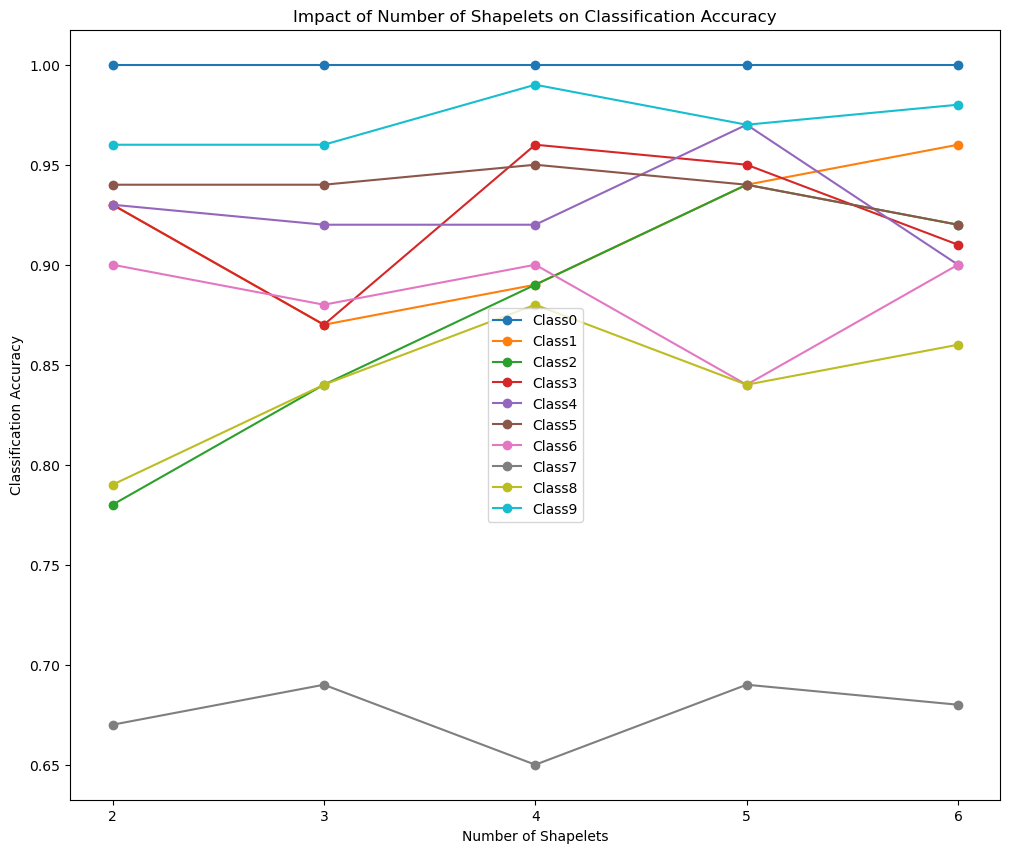

In [55]:
plt.figure(figsize=(12,10))
for i in range(len(scores[:10])):
    plt.plot([2,3,4,5,6],scores[i], marker='o', label= "Class" + str(i))
plt.xticks([2,3,4,5,6])
plt.xlabel("Number of Shapelets")
plt.ylabel("Classification Accuracy")
plt.title("Impact of Number of Shapelets on Classification Accuracy")
plt.legend()

In [ ]:
shapelets_pos = generate_random_shapelets(train_pos, 2)
shapelets_neg = generate_random_shapelets(train_neg, 2)

average_scores = []
for num_random in tqdm(range(2,11)):
    
    num_classes = 15
    scores = np.empty(num_classes)
    for chosen_class in range(15):
        filenames_pos, filenames_neg = generate_names(chosen_class)
        X_pos, X_neg, y = make_merged_trace_randsplit(train_pos, train_neg, chosen_class, num_random, num_traces=1000)
        parameter_list = get_parameter_list(filenames_pos, filenames_neg, shapelets_pos, shapelets_neg, X_pos, X_neg, y)

        with Pool(4) as p:
            p.map(compute_shapelet_distances_mp, parameter_list)
        
        score = classify_shapes(filenames_pos, filenames_neg)
        scores[chosen_class] = score
    
    average_scores.append(np.mean(scores))
    

100%|██████████| 1000/1000 [05:29<00:00,  3.04it/s]


Saving X as ../results/data/X/type=poscentroid_id=1class_id=0
Saving y as ../results/data/y/type=poscentroid_id=1class_id=0
Saving X as ../results/data/X/type=negcentroid_id=1class_id=0
Saving y as ../results/data/y/type=negcentroid_id=1class_id=0
Saving X as ../results/data/X/type=negcentroid_id=0class_id=0
Saving y as ../results/data/y/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=poscentroid_id=1class_id=0
Loading y from ../results/data/y/type=poscentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=0class_id=0
Loading X from ../results/data/X/type=negcentroid_id=1class_id=0
Loading y from ../results/data/y/type=negcentroid_id=0class_id=0


 11%|█         | 107/1000 [00:37<05:45,  2.58it/s]

In [65]:

# "saved" output from first experiment - correct trace is always in the same position
average_scores = [0.848, 0.840, 0.817, 0.799, 0.774, 0.76, 0.768, 0.764, 0.765]

# "saved" output from second experiment - correct trace is randomly assigned a position



Text(0.5, 0, 'Number of Samples in Trace (1-monitored x-unmonitored)')

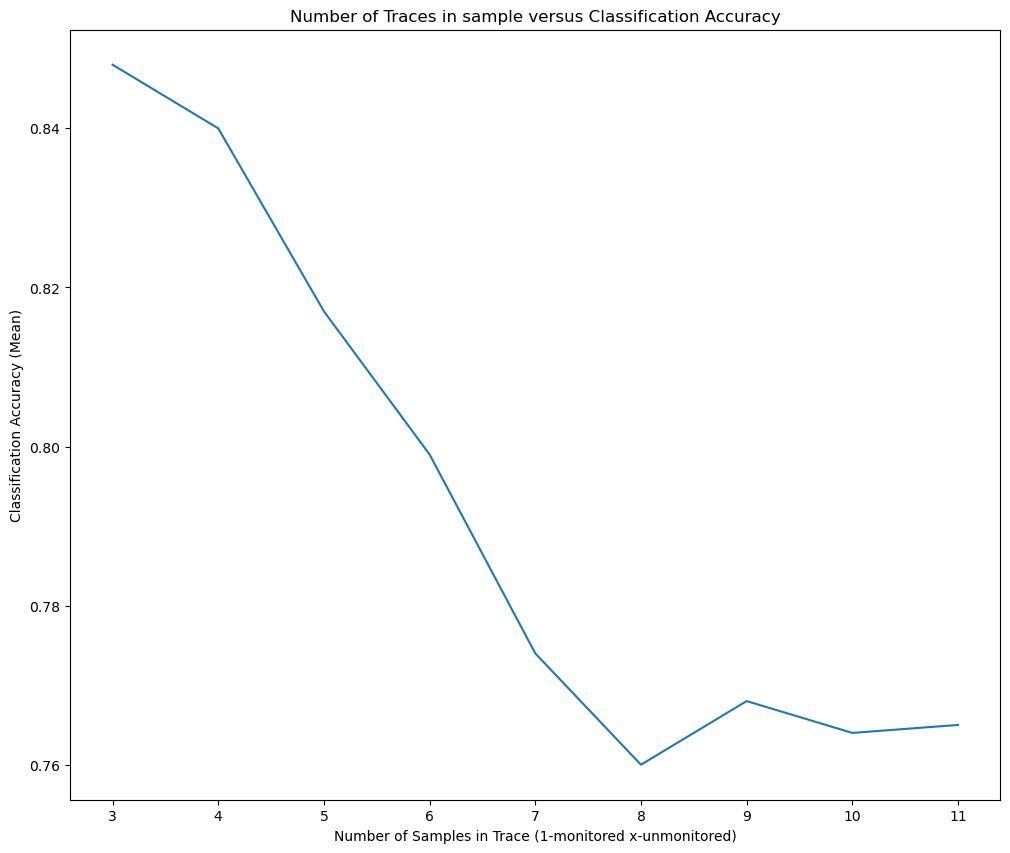

In [66]:
plt.figure(figsize=(12,10))
plt.plot([*range(3,12)], average_scores)
plt.xticks([*range(3,12)])
plt.title("Number of Traces in sample versus Classification Accuracy")
plt.ylabel("Classification Accuracy (Mean)")
plt.xlabel("Number of Samples in Trace (1-monitored x-unmonitored)")